In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(nn.functional.normalize(x, p=2, dim=1))
        return x
        
class multi_BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(multi_BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
        )
        self.strain_net = nn.Sequential(
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim//5*2)
        )
        self.stress_net = nn.Sequential(
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim//5*3)
        )
    def forward(self, x):
        x=self.net(nn.functional.normalize(x, p=2, dim=1))
        strain = self.strain_net(x)
        stress = self.stress_net(x)
        return strain, stress
        
class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.output_dim = output_dim
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        B1 = branch_output[:,:self.output_dim//5*1]
        B2 = branch_output[:,self.output_dim//5*1:self.output_dim//5*2]
        B3 = branch_output[:,self.output_dim//5*2:self.output_dim//5*3]
        B4 = branch_output[:,self.output_dim//5*3:self.output_dim//5*4]
        B5 = branch_output[:,self.output_dim//5*4:]
        
        T1 = trunk_output[:,:self.output_dim//5*1]
        T2 = trunk_output[:,self.output_dim//5*1:self.output_dim//5*2]
        T3 = trunk_output[:,self.output_dim//5*2:self.output_dim//5*3]
        T4 = trunk_output[:,self.output_dim//5*3:self.output_dim//5*4]
        T5 = trunk_output[:,self.output_dim//5*4:]
        
        s1 = torch.sum(B1 * T1,dim=1).view(-1,1)
        s2 = torch.sum(B2 * T2,dim=1).view(-1,1)
        s3 = torch.sum(B3 * T3,dim=1).view(-1,1)
        s4 = torch.sum(B4 * T4,dim=1).view(-1,1)
        s5 = torch.sum(B5 * T5,dim=1).view(-1,1)
        return s1, s2, s3, s4, s5

class multi_DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(multi_DeepONet, self).__init__()
        self.output_dim = output_dim
        self.branch_net = multi_BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        strain, stress = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        B1 = strain[:,:self.output_dim//5*1]
        B2 = strain[:,self.output_dim//5*1:]
        B3 = stress[:,:self.output_dim//5*1]
        B4 = stress[:,self.output_dim//5*1:self.output_dim//5*2]
        B5 = stress[:,self.output_dim//5*2:]
        
        T1 = trunk_output[:,:self.output_dim//5*1]
        T2 = trunk_output[:,self.output_dim//5*1:self.output_dim//5*2]
        T3 = trunk_output[:,self.output_dim//5*2:self.output_dim//5*3]
        T4 = trunk_output[:,self.output_dim//5*3:self.output_dim//5*4]
        T5 = trunk_output[:,self.output_dim//5*4:]
        
        s1 = torch.sum(B1 * T1,dim=1).view(-1,1)
        s2 = torch.sum(B2 * T2,dim=1).view(-1,1)
        s3 = torch.sum(B3 * T3,dim=1).view(-1,1)
        s4 = torch.sum(B4 * T4,dim=1).view(-1,1)
        s5 = torch.sum(B5 * T5,dim=1).view(-1,1)
        return s1, s2, s3, s4, s5

cuda


In [7]:
class PINN_Vibratec:
    def __init__(self, model):
        self.L = 200
        self.H = 50
        self.model = model
        self.Losses = []
        self.file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\PINNs_ElasticMechanics\\piDeepONet_Elastic_2D.pkl'
        self.train_set, self.test_set, self.train_keys, self.test_keys = self.load_Train_set()
        self.E = 1000
        self.rou = 0.3
        self.lamd = self.E * self.rou / (1 + self.rou) / (1 - 2 * self.rou)
        self.mu = self.E / 2 / (1 + self.rou)
        
    def load_model(self):
        self.model.load_state_dict(torch.load(self.file_name, weights_only=True))
        
    def u_function(self, B_data, T_data):
        u, v, s11, s22, s12 = self.model(B_data, T_data)
        return u, v, s11, s22, s12
        
    def stress_function(self, B_data, T_data):
        x = T_data[:,0:1]
        y = T_data[:,1:2]
        
        u_pred, v_pred, s11, s22, s12 = self.u_function(B_data,torch.hstack((x,y)))
        u_x = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u_pred, y, torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v_pred, x, torch.ones_like(v_pred), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v_pred, y, torch.ones_like(v_pred), retain_graph=True, create_graph=True)[0]
    
        s11_1 = torch.autograd.grad(s11, x, torch.ones_like(s11), retain_graph=True, create_graph=True)[0]
        s12_2 = torch.autograd.grad(s12, y, torch.ones_like(s12), retain_graph=True, create_graph=True)[0]
        s22_2 = torch.autograd.grad(s22, y, torch.ones_like(s22), retain_graph=True, create_graph=True)[0]
        s12_1 = torch.autograd.grad(s12, x, torch.ones_like(s12), retain_graph=True, create_graph=True)[0]
    
        e_xx = u_x
        e_yy = v_y
        e_xy = (u_y + v_x)/2.0
        e_kk = e_xx + e_yy
        factor = self.E / (1 - self.rou**2)
        
        sigma_xx = factor * (e_xx + self.rou * e_yy) - s11
        sigma_yy = factor * (self.rou * e_xx + e_yy) - s22
        sigma_xy = self.E / (2 * (1 + self.rou)) * (2 * e_xy) - s12
        
        # sigma_xx = self.lamd*e_kk + 2*self.mu*e_xx - s11
        # sigma_yy = self.lamd*e_kk + 2*self.mu*e_yy - s22
        # sigma_xy = 2*self.mu*e_xy - s12
    
        sigma_1 = s11_1 + s12_2   # 法向应力散度
        sigma_2 = s12_1 + s22_2   # 切向应力散度
        
        return sigma_xx, sigma_yy, sigma_xy, sigma_1, sigma_2
        
    def get_data_Loss(self, B_data, T_data, u_data, S_data):
        y_rand = (torch.rand_like(T_data[:, 1:2]) * 2 - 1) * self.H
        x_bc = torch.full_like(y_rand, -self.L)
        tc_data = torch.cat([x_bc, y_rand], dim=1).detach()
        tc_data.requires_grad = True
        tc_data = tc_data.to(device)
        
        u_pre, v_pre, sxx_pre, syy_pre, sxy_pre = self.u_function(B_data, T_data)
        u_bc, v_bc, _, _, _ = self.u_function(B_data, tc_data)
        u_ex = u_data[:,0:1]
        v_ex = u_data[:,1:2]
        sxx_ex = S_data[:,0:1]
        syy_ex = S_data[:,1:2]
        sxy_ex = S_data[:,2:3]
        loss = torch.mean(torch.square(u_pre - u_ex)) + torch.mean(torch.square(v_pre - v_ex)) + \
        torch.mean(torch.square(u_bc)) + torch.mean(torch.square(v_bc)) + \
        torch.mean(torch.square(sxx_pre-sxx_ex)) + torch.mean(torch.square(syy_pre-syy_ex)) + torch.mean(torch.square(sxy_pre-sxy_ex))
        return loss

    def get_pde_Loss(self, B_data, T_data, u_data, S_data):
        sigma_xx, sigma_yy, sigma_xy, sigma_1, sigma_2 = self.stress_function(B_data, T_data)
        
        loss = torch.mean(sigma_1 ** 2) + torch.mean(sigma_2 ** 2) + \
        torch.mean(sigma_xx ** 2) + torch.mean(sigma_yy ** 2) + torch.mean(sigma_xy ** 2)
        return loss
        
    def test_Loss(self, batch_size=10000):
        keys = self.test_keys
        total_loss = []
        for i,key in enumerate(keys):
            B_batch ,T_batch, u_batch, S_batch, _ = self.get_Test_data(i)
            u_pre, v_pre, _, _, _ = self.u_function(B_batch, T_batch)
            u_ex = u_batch[:,0:1]
            v_ex = u_batch[:,1:2]
            batch_loss = torch.square(u_pre - u_ex) + torch.square(v_pre - v_ex)
            total_loss.append(batch_loss.cpu().detach().numpy())
        return np.mean(np.concatenate(total_loss))

    def test_stress_Loss(self, batch_size=10000):
        keys = self.test_keys
        total_loss = []
        for i,key in enumerate(keys):
            B_batch ,T_batch, u_batch, S_batch, _ = self.get_Test_data(i)
            _, _, sigma_xx, sigma_yy, sigma_xy = self.u_function(B_batch, T_batch)
            sxx_ex = S_batch[:,0:1]
            syy_ex = S_batch[:,1:2]
            sxy_ex = S_batch[:,2:3]
            batch_loss = torch.square(sigma_xx - sxx_ex) + torch.square(sigma_yy - syy_ex) + torch.square(sigma_xy - sxy_ex)
            total_loss.append(batch_loss.cpu().detach().numpy())
        return np.mean(np.concatenate(total_loss))
        
    def train(self, epochs, learning_rate, step_size, gamma, pde_Nu = 200, pde_batch_size = 10, data_Nu = 2500, data_batch_size = 4):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.Losses.append(['total_loss','pde_loss','data_loss'])
        for epoch in range(epochs):
            if epoch % 1 == 0:
                # key_seed = np.random.randint(1, 100000)
                B_data, T_data, u_data, S_data = self.get_Train_data(data_Nu, data_batch_size,seed2 = 421)
                # B_pde_data, T_pde_data, u_pde_data, S_pde_data = self.get_Train_data(pde_Nu, pde_batch_size,seed = key_seed)
            self.optimizer.zero_grad()
            pde_loss = self.get_pde_Loss(B_data, T_data, u_data, S_data)
            data_loss = self.get_data_Loss(B_data, T_data, u_data, S_data)
            total_loss = data_loss + pde_loss
            total_loss.backward()
            self.Losses.append([total_loss.item(),pde_loss.item(),data_loss.item()])
            self.optimizer.step()
            self.scheduler.step()
            if epoch % 100 == 0:
                temp = zip(self.Losses[0],[round(num,8) for num in self.Losses[-1]])
                print(f"[Epoch {epoch+1}/{epochs}] {' '.join([':'.join([a,str(b)]) for a,b in temp])}")
                torch.save(self.model.state_dict(), self.file_name)
        temp = zip(self.Losses[0],self.Losses[-1])
        print(f"[Epoch {epoch+1}/{epochs}] {' '.join([':'.join([a,str(b)]) for a,b in temp])}")
        torch.save(self.model.state_dict(), self.file_name)
        print("Current learning rate:", self.optimizer.param_groups[0]['lr'])
        self.plot_loss()
        
    def plot_loss(self):
        plt.title('log(loss)')
        temp = np.array(self.Losses[1:])
        for i in range(temp.shape[1]):
            plt.plot(np.log(temp[:, i]).flatten(), label=self.Losses[0][i])
        plt.legend()
        plt.show()
        
    def predict(self, B_data, T_data):
        u_pre, v_pre, _, _, _ = self.u_function(B_data, T_data)
        u_pre = u_pre.cpu().detach().numpy()
        v_pre = v_pre.cpu().detach().numpy()
        return u_pre, v_pre

    def u_Exact(self, u_data):
        u_ex = u_data[:,0:1].cpu().detach().numpy()
        v_ex = u_data[:,1:2].cpu().detach().numpy()
        return u_ex, v_ex
        
    def plot_result(self, Numble=0):
        loss = self.test_Loss()
        print(f'Total Loss = {loss}')
        B_data, T_data, u_data, _, force = self.get_Test_data(Numble)

        print(f'Force = {force}')
        
        u_pre, v_pre = self.predict(B_data, T_data)
        u_ex, v_ex = self.u_Exact(u_data)
        x_np = T_data[:,0:1].cpu().detach().numpy()
        y_np = T_data[:,1:2].cpu().detach().numpy()

        X_pre = x_np + u_pre
        Y_pre = y_np + v_pre

        X_ex = x_np + u_ex
        Y_ex = y_np + v_ex
        
        u_err = np.abs(u_ex - u_pre)
        v_err = np.abs(v_ex - v_pre)
        
        print(f'RMSE U = {np.linalg.norm(u_err)/np.linalg.norm(u_ex)} RMSE V = {np.linalg.norm(v_err)/np.linalg.norm(v_ex)}')
        
        plt.figure(figsize=(18,9))
        plt.subplot(2,3,1)
        plt.scatter(X_pre, Y_pre, c = u_pre, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Pre')
        plt.tight_layout()
        
        plt.subplot(2,3,2)
        plt.scatter(X_ex, Y_ex, c = u_ex, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Exact')
        plt.tight_layout()
        
        plt.subplot(2,3,3)
        plt.scatter(X_pre, Y_pre, c = u_err, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('U Error')
        plt.tight_layout()
        
        plt.subplot(2,3,4)
        plt.scatter(X_pre, Y_pre, c = v_pre, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Pre')
        plt.tight_layout()
        
        plt.subplot(2,3,5)
        plt.scatter(X_ex, Y_ex, c = v_ex, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Exact')
        plt.tight_layout()
        
        plt.subplot(2,3,6)
        plt.scatter(X_pre, Y_pre, c = v_err, cmap='bwr')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('V Error')
        plt.tight_layout()
        
        plt.show()
        
    def plot_stress(self, Numble=0):
        loss = self.test_stress_Loss()
        print(f'Total Stress Loss = {loss}')
        B_data, T_data, u_data, S_data, force = self.get_Test_data(Numble)
        
        u_ex, v_ex = self.u_Exact(u_data)
        sxx_ex = S_data[:,0:1].cpu().detach().numpy()
        syy_ex = S_data[:,1:2].cpu().detach().numpy()
        sxy_ex = S_data[:,2:3].cpu().detach().numpy()
        print(f'Force = {force}')
        
        x_np = T_data[:,0:1].cpu().detach().numpy()
        y_np = T_data[:,1:2].cpu().detach().numpy()
        
        X_ex = x_np + u_ex
        Y_ex = y_np + v_ex
        
        _, _, sigma_xx, sigma_yy, sigma_xy = self.u_function(B_data, T_data)
        sigma_xx = sigma_xx.cpu().detach().numpy()
        sigma_yy = sigma_yy.cpu().detach().numpy()
        sigma_xy = sigma_xy.cpu().detach().numpy()
        
        sxx_err = np.abs(sigma_xx - sxx_ex)
        syy_err = np.abs(sigma_yy - syy_ex)
        sxy_err = np.abs(sigma_xy - sxy_ex)
        
        print(f'RMSE Sxx = {np.linalg.norm(sxx_err)/np.linalg.norm(sxx_ex)} RMSE Syy = {np.linalg.norm(syy_err)/np.linalg.norm(syy_ex)} \
RMSE Sxy = {np.linalg.norm(sxy_err)/np.linalg.norm(sxy_ex)}')
        
        plt.figure(figsize=(18,14))
        for i, temp in enumerate([[sigma_xx,sxx_ex,sxx_err,'Sxx'], [sigma_yy,syy_ex,syy_err,'Syy'], [sigma_xy,sxy_ex,sxy_err,'Sxy']]):
            plt.subplot(3,3,1+3*i)
            plt.scatter(X_ex, Y_ex, c = temp[0], cmap='bwr')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(temp[3]+' Pre')
            plt.tight_layout()
            
            plt.subplot(3,3,2+3*i)
            plt.scatter(X_ex, Y_ex, c = temp[1], cmap='bwr')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(temp[3]+' Exact')
            plt.tight_layout()
            
            plt.subplot(3,3,3+3*i)
            plt.scatter(X_ex, Y_ex, c = np.abs(temp[2]), cmap='bwr')
            plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(temp[3]+' Error')
            plt.tight_layout()
        plt.show()
        
    def get_Train_data(self, Nu, batch_size=1, seed1=None, seed2=None):
        # 防止seed污染全局
        rng1 = np.random.default_rng(seed1)
        rng2 = np.random.default_rng(seed2)
        
        all_keys = list(self.train_set.keys())
        selected_keys = rng1.choice(all_keys, size=batch_size, replace=True)
        B_list, T_list, u_list, S_list = [], [], [], []
        for key in selected_keys:
            df = self.train_set[key]
            uv_tail = df.iloc[10000:][['u', 'v']].values
            B = uv_tail.flatten()[np.newaxis, :]  # (1, 2n)
            B = np.repeat(B, Nu, axis=0)          # (Nu, 2n)
            sampled = df.iloc[:10000].sample(n=Nu, random_state=rng2.integers(1e9) if seed2 is not None else None)
            T = sampled[['x', 'y']].values
            u = sampled[['u', 'v']].values
            S = sampled[['sxx', 'syy', 'sxy']].values
            
            B_list.append(B)
            T_list.append(T)
            u_list.append(u)
            S_list.append(S)
        B_data = torch.tensor(np.vstack(B_list), dtype=torch.float32, requires_grad=True).to(device)
        T_data = torch.tensor(np.vstack(T_list), dtype=torch.float32, requires_grad=True).to(device)
        u_data = torch.tensor(np.vstack(u_list), dtype=torch.float32, requires_grad=True).to(device)
        S_data = torch.tensor(np.vstack(S_list), dtype=torch.float32, requires_grad=True).to(device)
        return B_data, T_data, u_data, S_data
        
    def get_Test_data(self, Numble=0):
        key = list(self.test_set.keys())[Numble]
        sampled_data = self.test_set[key]
        B_data = sampled_data.iloc[10000:][['u', 'v']].values
        B_data = B_data.flatten()[np.newaxis, :]
        B_data = np.repeat(B_data, 10000, axis=0)
        T_data = sampled_data.iloc[:10000][['x','y']]
        u_data = sampled_data.iloc[:10000][['u','v']]
        S_data = sampled_data.iloc[:10000][['sxx','syy','sxy']]
        B_data = torch.tensor(np.array(B_data), dtype=torch.float32, requires_grad=True).to(device)
        T_data = torch.tensor(np.array(T_data), dtype=torch.float32, requires_grad=True).to(device)
        u_data = torch.tensor(np.array(u_data), dtype=torch.float32, requires_grad=True).to(device)
        S_data = torch.tensor(np.array(S_data), dtype=torch.float32, requires_grad=True).to(device)
        return B_data, T_data, u_data, S_data, key
        
    def load_Train_set(self):
        data_set = {}
        folder_path = 'D:\DeepLearningDataset\DeepONet_Elastic_2D'
        file_names = os.listdir(folder_path)
        for file_name in file_names:
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data_set[file_name[:4]] = pd.read_csv(file)
                    pass
        keys = list(data_set.keys())
        print(len(keys))
        np.random.shuffle(keys)
        train_keys = keys[:int(len(keys)*0.8)]
        test_keys = keys[int(len(keys)*0.8):]
        train_set = {key: data_set[key] for key in train_keys}
        test_set = {key: data_set[key] for key in test_keys}
        return train_set, test_set, train_keys, test_keys

[Epoch 1/10000] total_loss:8.16291237 pde_loss:1.54508197 data_loss:6.61783075
[Epoch 101/10000] total_loss:11.83927155 pde_loss:1.28083467 data_loss:10.55843639
[Epoch 201/10000] total_loss:34.32541656 pde_loss:3.21343112 data_loss:31.11198616
[Epoch 301/10000] total_loss:15.33036804 pde_loss:1.77593601 data_loss:13.55443192
[Epoch 401/10000] total_loss:8.01444244 pde_loss:1.14479876 data_loss:6.86964369
[Epoch 501/10000] total_loss:3.68166494 pde_loss:0.57535839 data_loss:3.10630655
[Epoch 601/10000] total_loss:0.7865001 pde_loss:0.15855899 data_loss:0.62794113
[Epoch 701/10000] total_loss:5.87997246 pde_loss:0.79126477 data_loss:5.08870745
[Epoch 801/10000] total_loss:21.49473763 pde_loss:2.15523934 data_loss:19.33949852
[Epoch 901/10000] total_loss:17.94931984 pde_loss:1.66567266 data_loss:16.28364754
[Epoch 1001/10000] total_loss:14.79875088 pde_loss:1.71343255 data_loss:13.08531857
[Epoch 1101/10000] total_loss:0.31230479 pde_loss:0.08304892 data_loss:0.22925588
[Epoch 1201/10000

TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

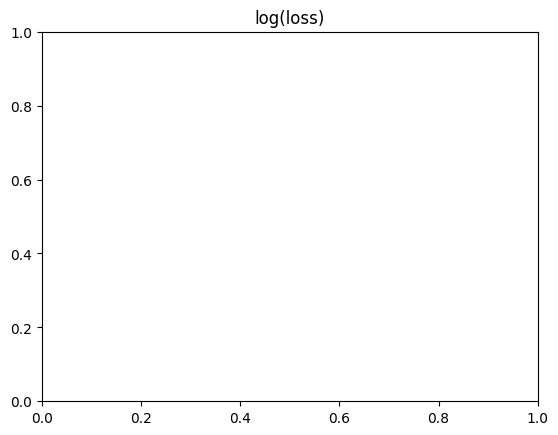

In [11]:
# PINNs_model = PINN_Vibratec(DeepONet(202, 2, 300, 300).to(device))
PINNs_model = PINN_Vibratec(multi_DeepONet(202, 2, 300, 300).to(device))
PINNs_model.load_model()
PINNs_model.train(epochs=10000,learning_rate=1e-5,step_size=500,gamma=0.85,pde_Nu=5000,pde_batch_size=2,data_Nu=5000,data_batch_size=2)

Total Loss = 9.49316120147705
Force = 2.88
RMSE U = 0.3614721894264221 RMSE V = 0.019687162712216377


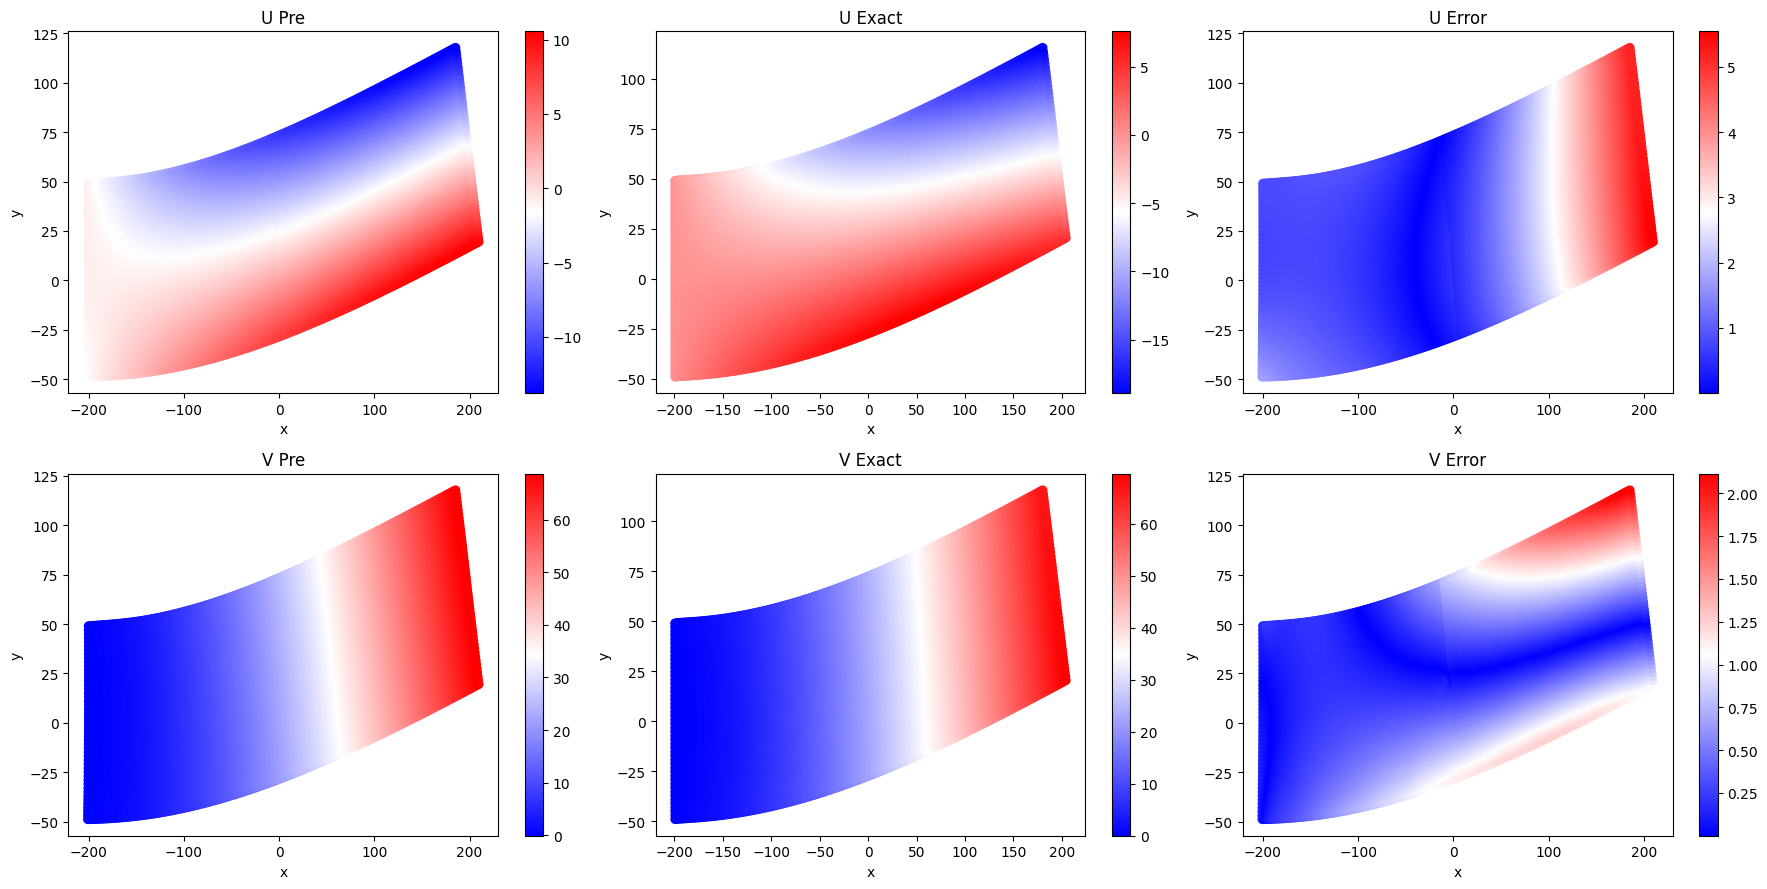

Total Loss = 9.49316120147705
Force = 0.06
RMSE U = 0.42962414026260376 RMSE V = 0.3609730899333954


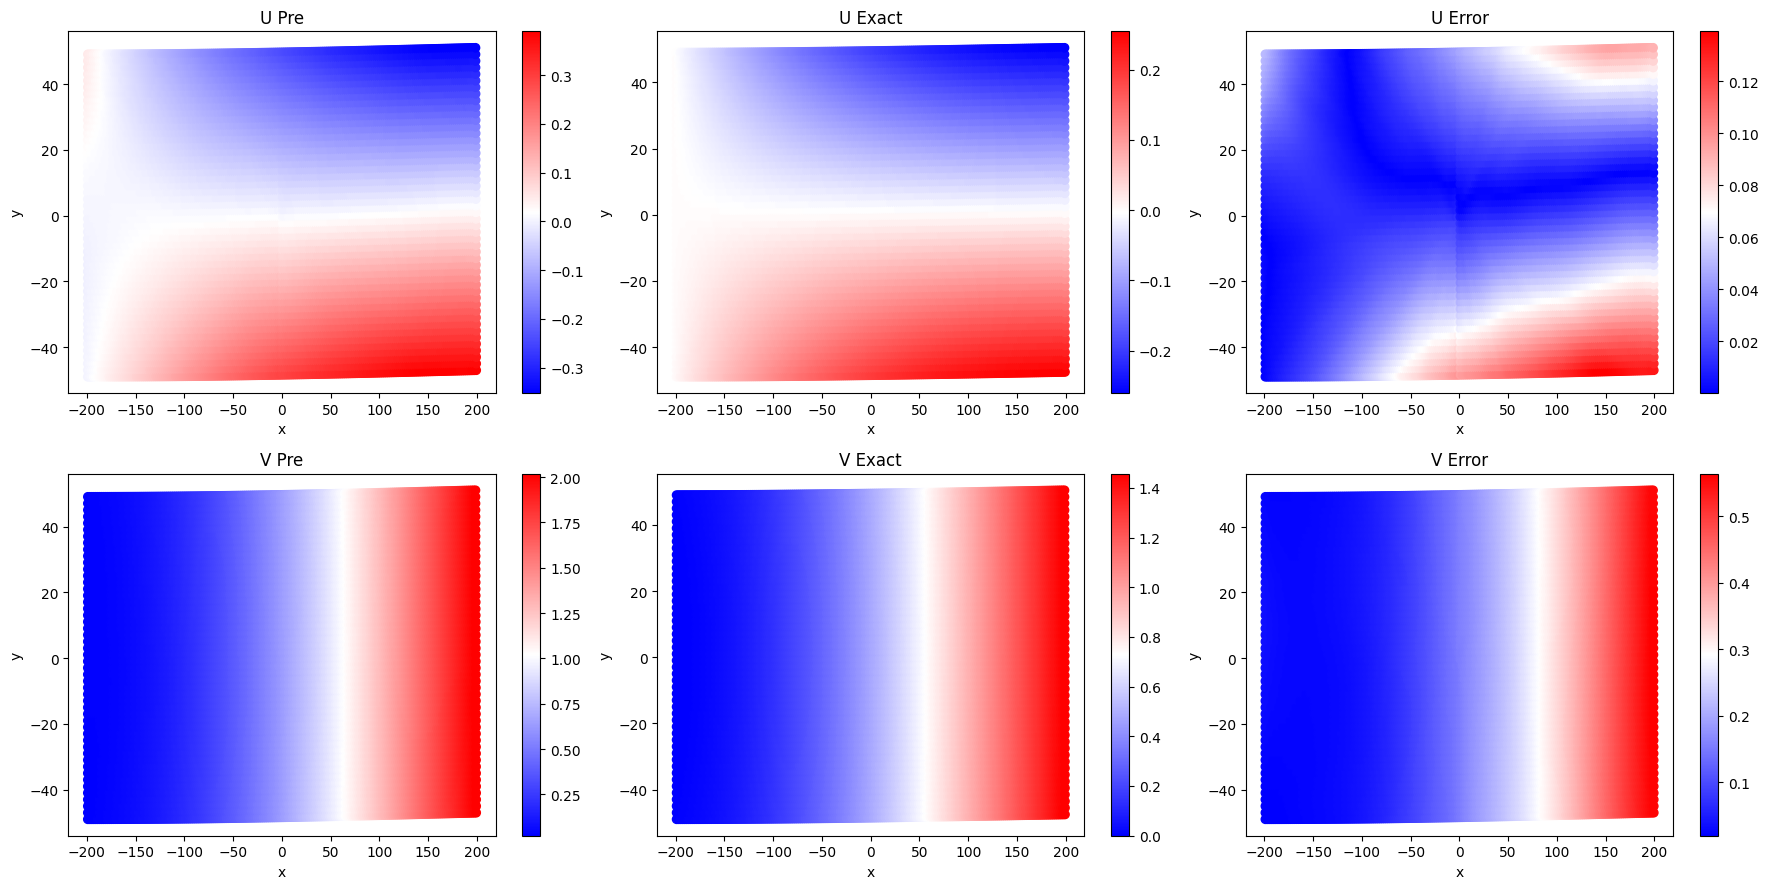

Total Loss = 9.49316120147705
Force = 4.78
RMSE U = 0.49089449644088745 RMSE V = 0.029182251542806625


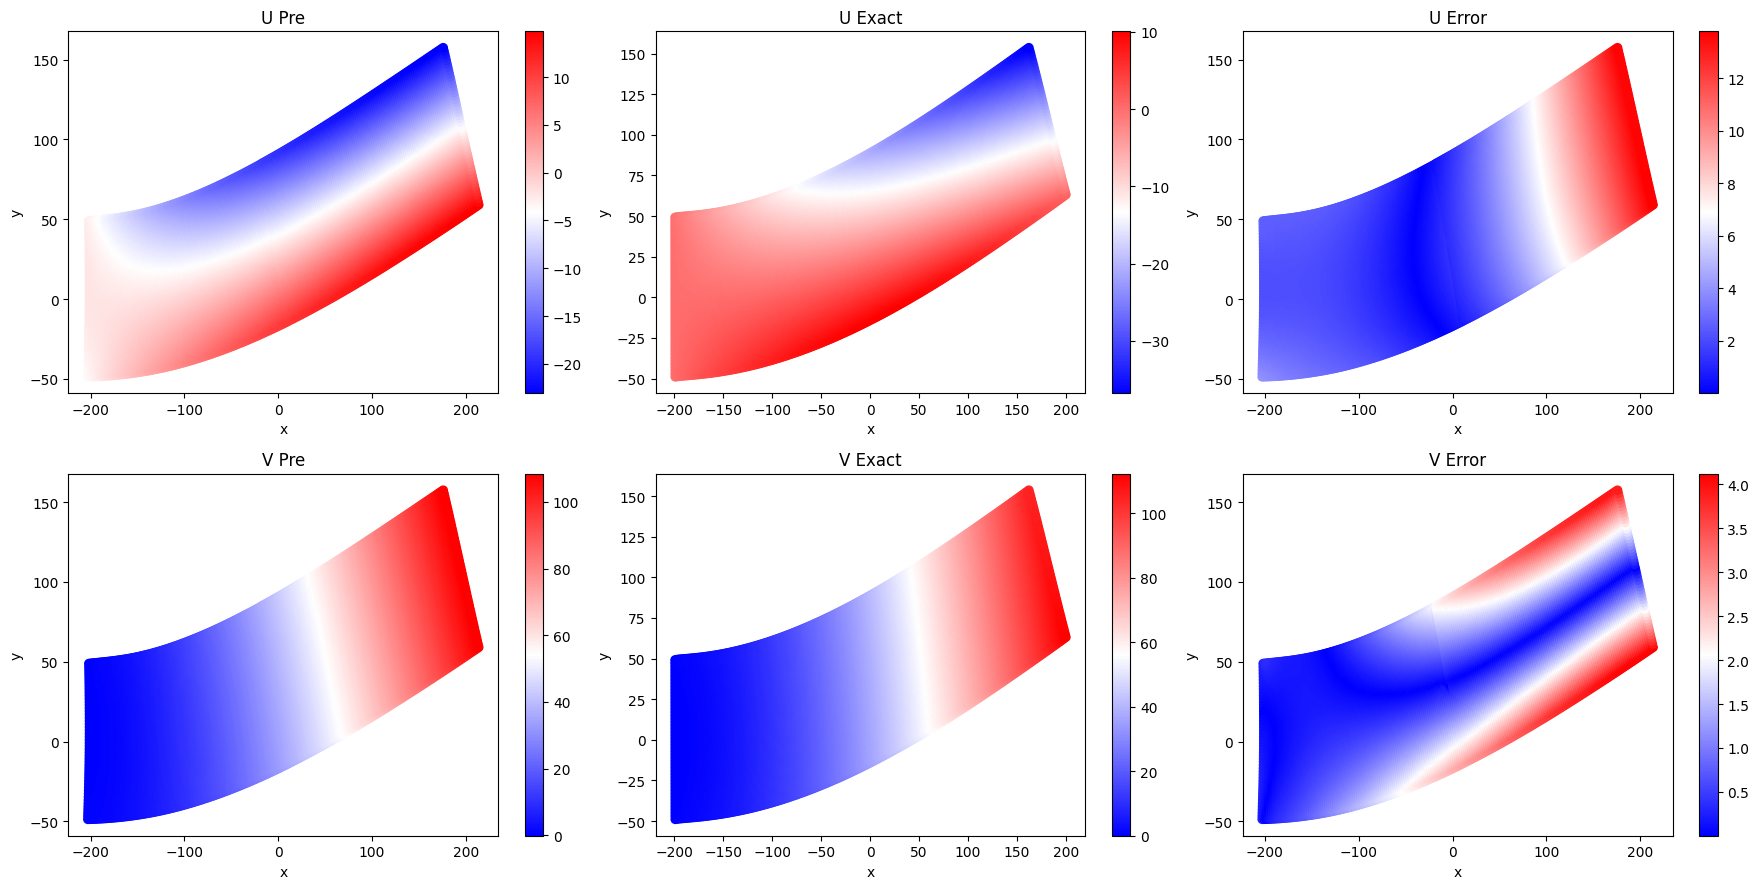

In [53]:
# model = DeepONet(202, 2, 200, 500).to(device)
# PINNs_model = PINN_Vibratec(model)
# PINNs_model.load_model()
PINNs_model.plot_result(0)
PINNs_model.plot_result(1)
PINNs_model.plot_result(2)

Total Stress Loss = 1.7056162357330322
Force = 2.88
RMSE Sxx = 0.037167441099882126 RMSE Syy = 0.25709861516952515 RMSE Sxy = 0.11596899479627609


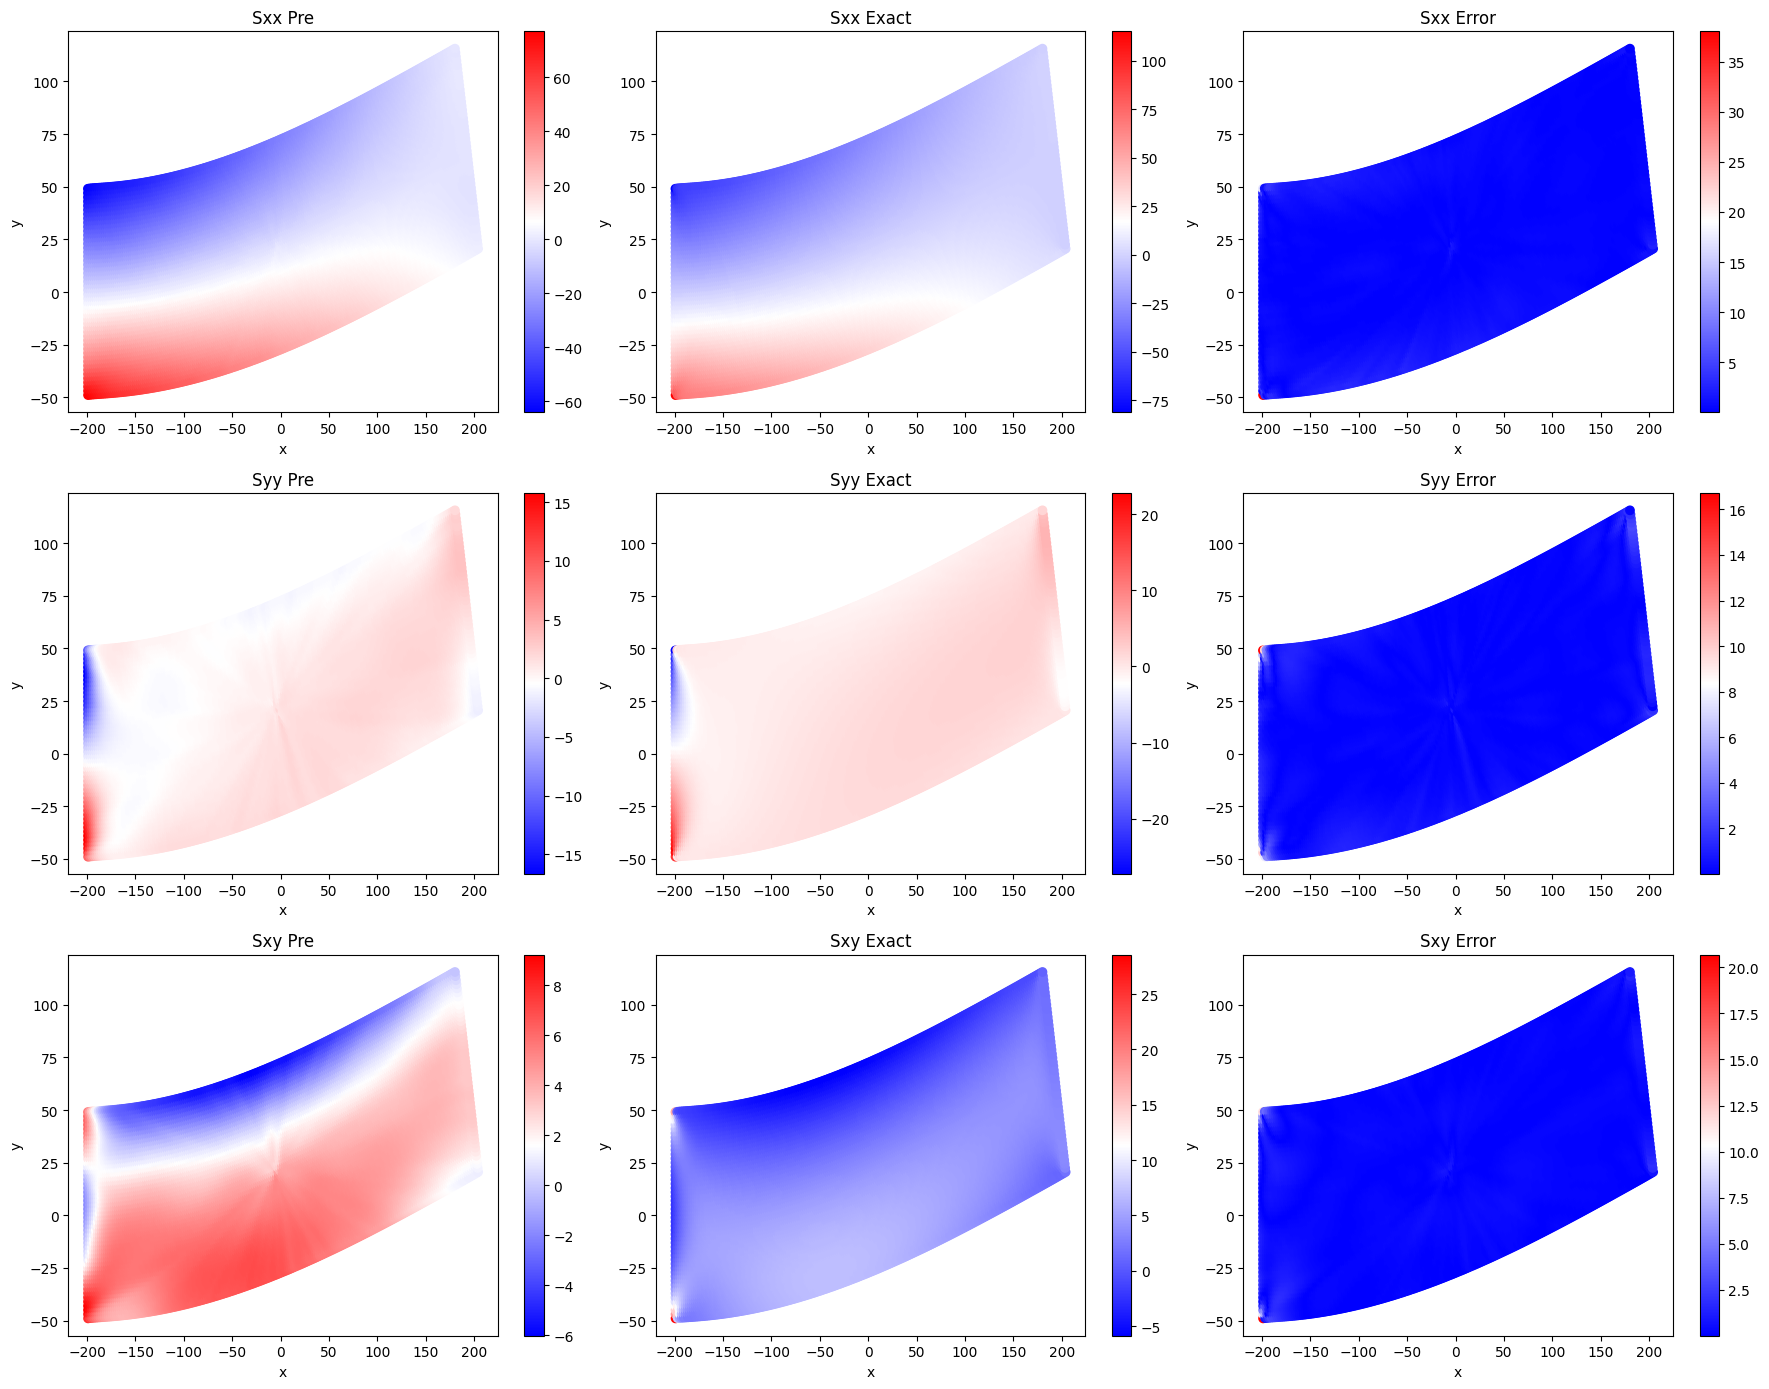

Total Stress Loss = 1.7056162357330322
Force = 0.06
RMSE Sxx = 0.5919771790504456 RMSE Syy = 3.3832852840423584 RMSE Sxy = 2.6467630863189697


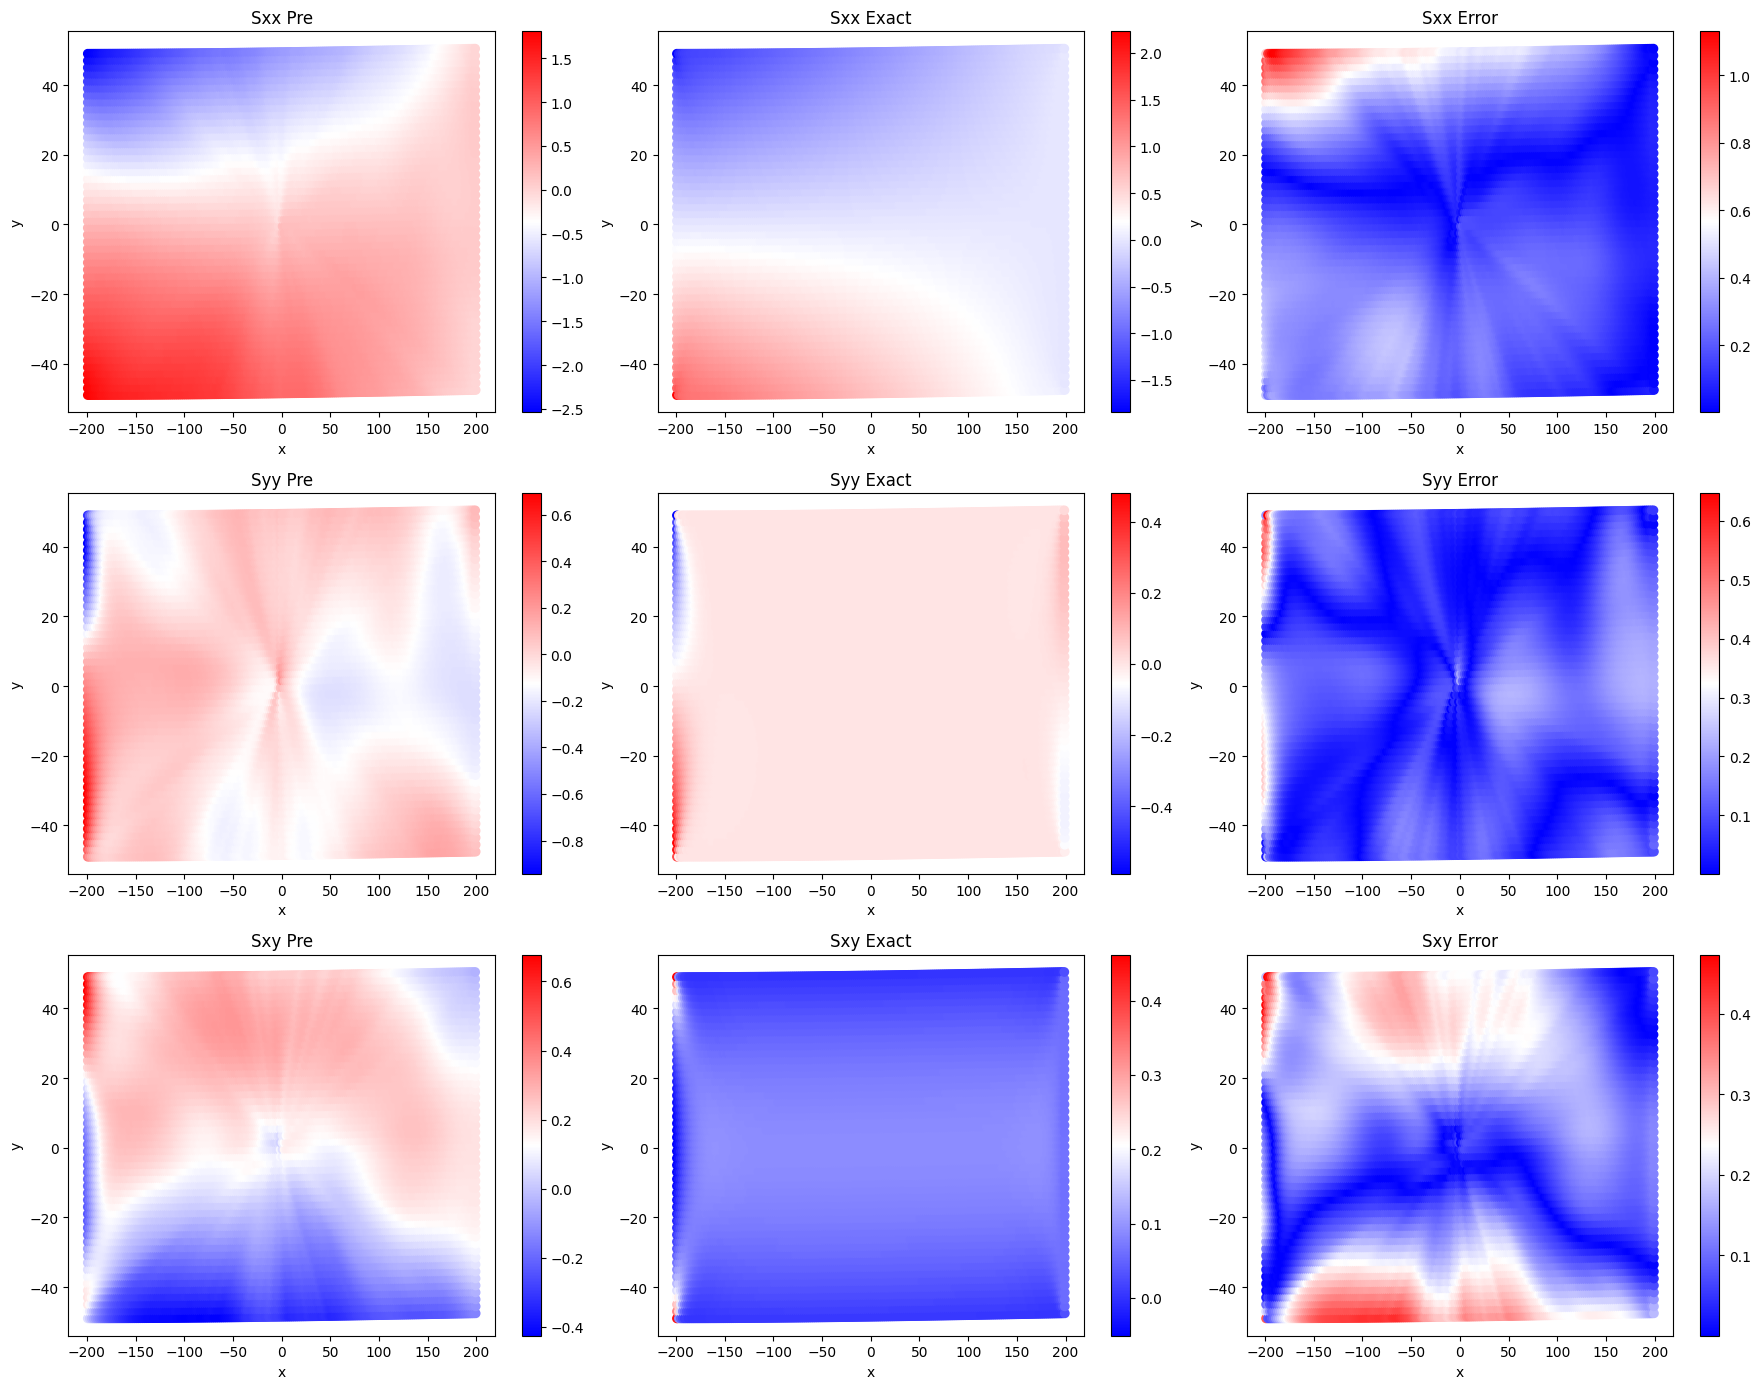

In [54]:
PINNs_model.plot_stress(0)
PINNs_model.plot_stress(1)